Late time kilonova calculations

In [1]:
'''Libraries'''
#Data
import pandas as pd

#Plots
import matplotlib.pyplot as plt

#math
import numpy as np

#Constants
from scipy.constants import speed_of_light as c
from scipy.constants import Boltzmann as kb
from scipy.constants import Stefan_Boltzmann as Sb

#Usefull
from tqdm.notebook import tqdm
from scipy.interpolate import interp1d
%matplotlib widget

In [2]:
'''Abundancias en funcion del tiempo

este codigo carga 554 archivos, cada archivo representa un valor de t en tiempos desde t=2.3E-05 Segundos hasta t=8.64E+06 segundos (100 dias)
 
para cada tiempo hay un archivo de con la siguiente estructura:
    time    temp    dens
   8.64000000000000E+06   1.00000000000000E-02   6.12595382759495E-19
     nin     zin       y       x
  1    0     1.81077137723961E-19   1.81077137723961E-19
  0    1     2.16780459396517E-09   2.16780459396517E-09
  1    1     9.43321881521884E-11   1.88664376304377E-10
  2    1     2.37487509969422E-12   7.12462529908266E-12
  1    2     5.10414497594859E-14   1.53124349278458E-13
  2    2     3.41978236767250E-04   1.36791294706900E-03

nin es el numero de neutrones, zin es el numero de protones, y es number fraction y x es el mass fraction 

La lista Xi_ts es una lista donde cada elemento corresponde a una matriz de 4 columnas (nin,zin,y,x) y el indice del elemento corresponde a un cierto valor de t
La lista ts es una lista donde ts[i] es el valor de tiempo del archivo i e.j t[0]=2.3E-5

'''
Xi_ts=[]
ts=[]
for i in tqdm(range(1,555)):
    datos=pd.read_csv(r'Example_NSM_dyn_ejecta_rosswog_varios_t_sinalpha\snaps'+f'\snapsh_{i:04d}.dat', skiprows=3, delim_whitespace=True, names=['nin', 'zin', 'y', 'x'],dtype={'nin':int,'zin':int,'y':float,'x':float})
    Xi_ts.append(datos)
    df = pd.read_csv(r'Example_NSM_dyn_ejecta_rosswog_varios_t_sinalpha\snaps'+f'\snapsh_{i:04d}.dat', skiprows=1, nrows=1, delim_whitespace=True, header=None)
    ts.append(df[0][0])
    
ts=np.array(ts)
Xi_ts=np.array(Xi_ts)



  0%|          | 0/554 [00:00<?, ?it/s]

In [3]:
'''Interpolacion Lineal

En esta parte creamos una nueva lista Xi_t_i donde cada elemento representa una lista de (x) para cualquier tiempo entre 1 segundo y
100 dias en 10000 pasos (Xi_ts solo tenia 554 pasos). 

'''
t = np.exp(np.linspace(0, 15.971, 10000))
Xi_t_i= np.empty((len(t), Xi_ts.shape[1]))
for i in tqdm(range(Xi_ts.shape[1])):
    spline_interp = interp1d(ts, Xi_ts[:,i,3], kind='linear', fill_value="extrapolate")
    Xi_t_i[:, i] = spline_interp(t)


  0%|          | 0/6757 [00:00<?, ?it/s]

In [4]:
'''Esta funcion devuelve el indice i asociado tanto a la lista Xi_t_i[t] y Xi_ts[ts] que corresponde al nucleo (n,z)'''
columna_z=Xi_ts[0][:,1]
columna_n=Xi_ts[0][:,0]
def find_i_n_z(n,z):
    
    idx_start = np.searchsorted(columna_z, z, side='left')
    idx_end = np.searchsorted( columna_z, z, side='right')
    if idx_end>idx_start:
        j=np.searchsorted(columna_n[idx_start:idx_end],n)+idx_start
        if columna_n[j]==n and columna_z[j]==z:
            return j
        else:
            return 'no hay'
    else:
        return 'no hay'
    
'''Esta funcion devuelve la abundancia en funcion del tiempo de un nucleo (n,z)'''
def Xi_t(n,z):
    
    h=find_i_n_z(n,z)
    if h!='no hay':
        return Xi_t_i[:,h]
    elif h=='no hay':
        return np.zeros(10000)


Text(0.5, 1.0, 'Example of Xi(t) for n=118, z= 76')

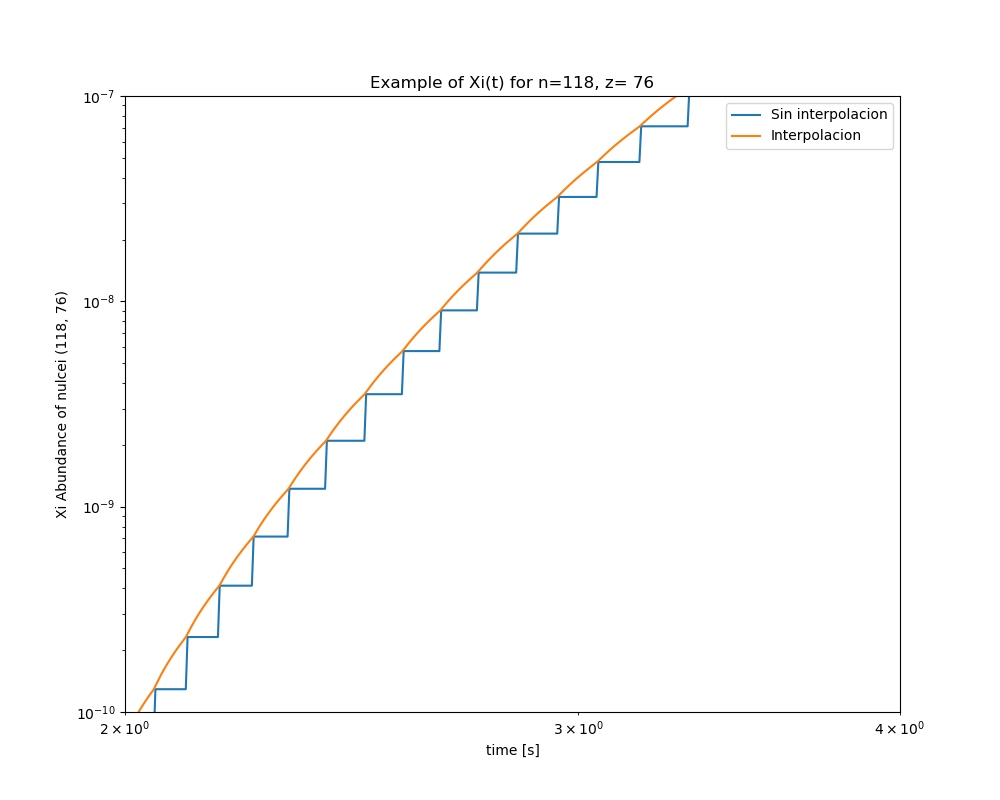

In [5]:
'''Codigo para monitorear la abundnacia de un cierto nucleo'''
n_graph=118
p_graph=76

fig, ax1 = plt.subplots(1,1,figsize=(10, 8))
cax1=ax1.plot(t,Xi_ts[np.searchsorted(ts,t)-1][:,find_i_n_z(n_graph,p_graph)][:,3],label="Sin interpolacion")#caso discreto
cax2=ax1.plot(t,Xi_t_i[:,find_i_n_z(n_graph,p_graph)],label="Interpolacion")#interpolacion
ax1.set_xscale("log")
ax1.set_ylabel(f'Xi Abundance of nulcei {n_graph,p_graph}')
ax1.set_xlabel("time [s]")
ax1.set_yscale("log")
ax1.set_xlim((2,4))
ax1.set_ylim((1E-10,1E-7))
ax1.legend()
ax1.set_title("Example of Xi(t) for n="+str(n_graph)+", z= "+str(p_graph))

In [5]:
'''Datos de decaimientos'''

datos=pd.read_csv('Datos_decaimientos_Beta_Alpha.csv')
Decay_modes=datos['decayModes']
Z=datos['z']
N=datos['n']
Name=datos['name']
Level_energy=datos['levelEnergy(MeV)']
Half_life=datos['halflife']
Half_life_unit=datos['halflifeUnit']

Mass_exces=datos['massExcess(keV)']
Q_beta=datos['betaMinus(keV)']
Q_alpha=datos['alpha(keV)']

def convertir_a_segundos(T,unit):
    R=0
    if unit!='s':
        if unit=='y':
            R=365*24*60*60*T
        elif unit=='m':
            R=60*T
        elif unit=='ms':
            R=T/1000
        elif unit=='ns':
            R=T/1000000000
        elif unit=='h':
            R=T*60*60
        elif unit =='d':
            R=T*60*60*24
        elif unit == 'us':
            R=T/1000000
        elif unit=='mev':
            R=(np.log(2)*6.582119E-22)/(T)
        elif unit=='ev':
            R=(np.log(2)*6.582119E-16)/(T)
        elif unit=='kev':
            R=(np.log(2)*6.582119E-19)/(T)
    else:
        R=T
    return float(R)

In [6]:
'''Calculo tasa de generacion de energia'''
E_alpha_aporte=[]
Name_alpha=[]
E_beta_aporte=[]
Name_beta=[]
Nuclei_beta=[]
Nuclei_alpha=[]
E_beta=np.zeros(10000)
E_alpha=np.zeros(10000)
XA=0

for i in tqdm(range(len(Decay_modes))):
    l=Level_energy[i]
    
    deca=Decay_modes[i]
    w=deca.split(' ')
    if Level_energy[i]==0:
        if w[0]=='B-' and w[2]!='': #and Z[i]<111 and N[i]<226:
            p=float(w[2])/100
            lamb=np.log(2)/convertir_a_segundos(Half_life[i],Half_life_unit[i])
            d=p*(c**2)*Q_beta[i]*lamb/((Z[i]+N[i])*931494.103+Mass_exces[i])
            if d!=0:
                e=d*Xi_t(N[i],Z[i])*np.exp(-lamb*t)
                E_beta_aporte.append(e)
                Name_beta.append(Name[i])
                E_beta+=e
                Nuclei_beta.append([N[i],Z[i]])


        if w[0]=='A' and w[2]!='':# and Z[i]<111 and N[i]<226:
            p=float(w[2])/100
            lamb=np.log(2)/convertir_a_segundos(Half_life[i],Half_life_unit[i])
            d=p*(c**2)*Q_alpha[i]*lamb/((Z[i]+N[i])*931494.103+Mass_exces[i])
            if d!=0 and not np.isnan(d):
                e=d*Xi_t(N[i],Z[i])*np.exp(-lamb*t)
                E_alpha_aporte.append(e)
                Name_alpha.append(Name[i])
                E_alpha+=e
                Nuclei_alpha.append([N[i],Z[i]])
                if N[i]+Z[i]>=210:
                    XA+=Xi_t(N[i],Z[i])
                    
    
E_alpha_aporte=np.array(E_alpha_aporte)
E_beta_aporte=np.array(E_beta_aporte)     
E_alpha_aporte_n=(E_alpha_aporte)/E_alpha
E_beta_aporte_n=(E_beta_aporte)/E_beta

  0%|          | 0/3421 [00:00<?, ?it/s]

In [7]:
'''Calculations and Termalization'''
#Important Values
Mey=0.05
Vey=0.15#c


#time
t_dias=t*(1/(60*60*24))#s

#termalizations
tb=12.9*(Mey/0.01)**(2/3)*(Vey/0.2)**(-2)*24*60*60 #termalization beta particles
ty=0.3*(Mey/0.01)**(1/2)*(0.2/Vey)*24*60*60 ##termalization gamma particles
f_gamma=1-np.exp(-(ty/t)**2)
f_electrons=(1+t/tb)**(-1)
f_beta=0.2*f_electrons+0.5*f_gamma
f_alpha=(1+t/(3*tb))**(-1)

#Termalization*Heating rate
E_alpha_efectivo=E_alpha*f_alpha
E_beta_efectivo=E_beta*f_beta
E_alpha_erg=(10**4)*E_alpha_efectivo#erg/g*s
E_beta_erg=(10**4)*E_beta_efectivo#erg/g*s

#total Efective Heating
E_total_efectivo=E_beta_efectivo+E_alpha_efectivo



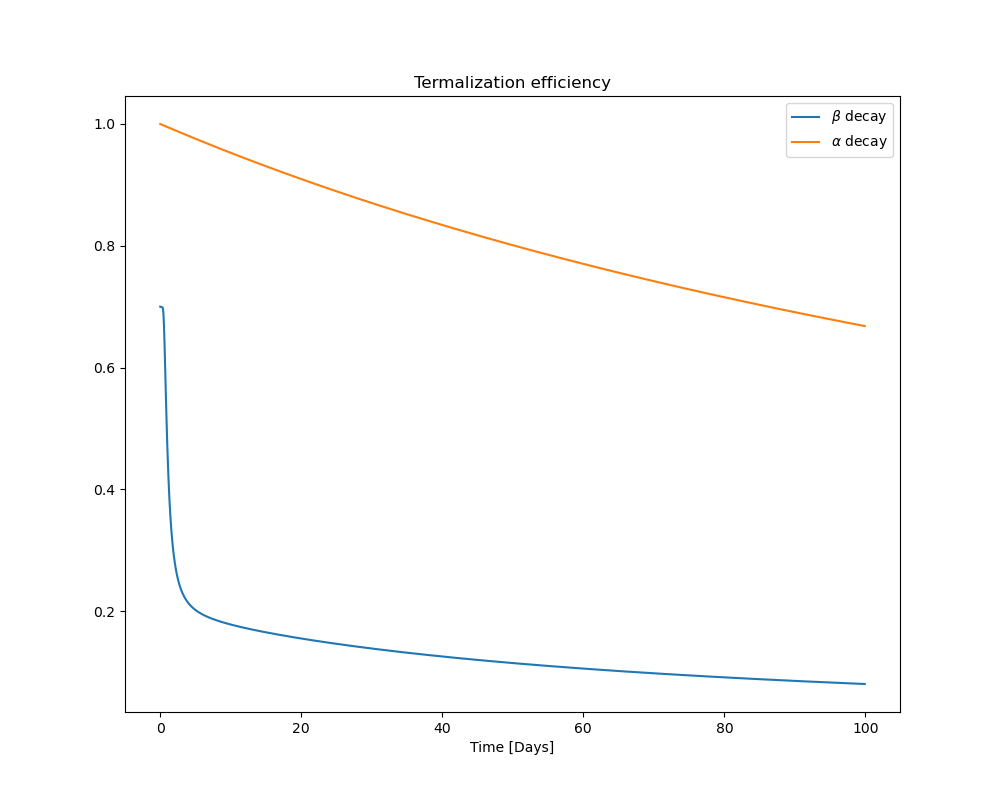

In [8]:
''' Termalization plot '''

plt.figure(figsize=(10,8))
plt.plot(t_dias,f_beta,label=r'$\beta$ decay')
plt.plot(t_dias,f_alpha,label=r'$\alpha$ decay')
plt.title('Termalization efficiency')
plt.xlabel('Time [Days]')
plt.legend()


In [ ]:
''' Other Models for Heating Rate'''
#Rosswog 2012 whole simulation data
datos_win=pd.read_csv(r'C:\Users\Diego_Hernandez\winnet\WinNet-master\WinNet-master\runs\Example_NSM_dyn_ejecta_rosswog_varios_t_sinalpha\generated_energy.dat',skiprows=2,names=['t','e','1','2' ,'3','4','5','6','7','8','9'], delim_whitespace=True)
t_win=datos_win['t']/(60*60*24)
f_gamma_win=1-np.exp(-(ty/t_win)**2)
f_electrons_win=(1+t_win/tb)**(-1)
f_beta_win=0.2*f_electrons_win+0.5*f_gamma_win
f_alpha_win=(1+t_win/(3*tb))**(-1)
E_beta_win=f_beta_win*datos_win['e']
E_fiss_win=f_alpha_win*datos_win['9']

#aproximation
E_korobkin=(4*10**18)*(0.5-(1/np.pi)*np.arctan((t-1.3)/0.11))**(1.3)

#Power Law Hotokezaka
E_hoto_e=(4*10**9)*(t_dias)**(-1.3)
E_hoto_g=(8*10**9)*(t_dias)**(-1.3)
E_hoto_a=(7*10**8)*(1/t_dias)*(XA/3e-2)
E_hoto_f=(2.10**5)*(1/t_dias)
E_Hoto=E_hoto_e+E_hoto_g+E_hoto_a+E_hoto_f

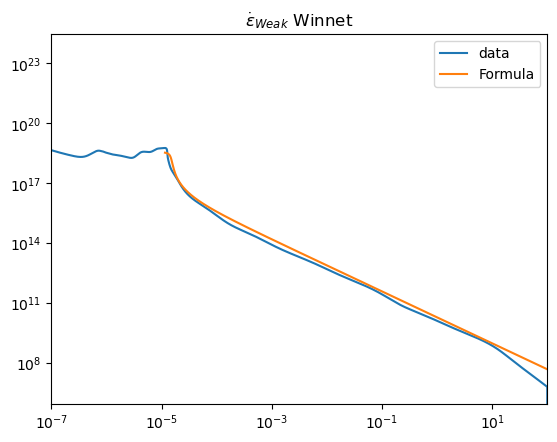

In [ ]:
'''Plot Heating rate whole data vs formula korokin and rosswog'''
plt.figure()
plt.plot(t_win,E_beta_win,label='data')
plt.plot(t/(60*60*24),E_korobkin,label='Formula')
plt.title(r"$\dot\epsilon_{Weak}$ Winnet")
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlim(left=1e-7,right=100)

plt.show()

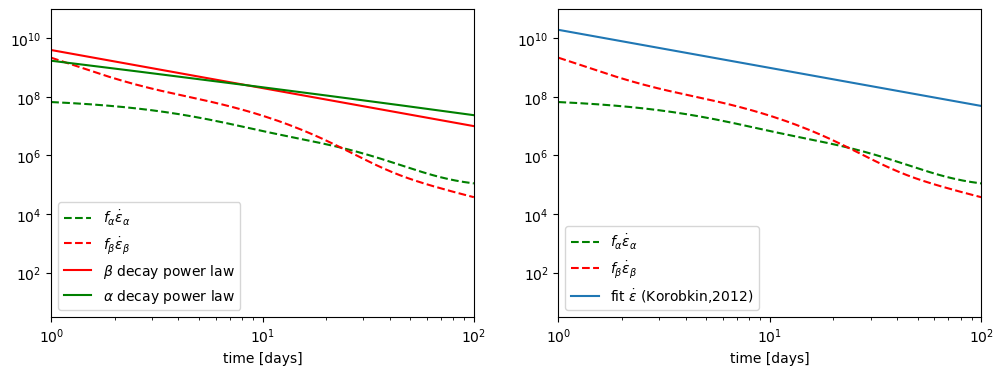

In [ ]:
'''Figure 1. article, plot Heating rates for models'''
fig, (ax2, ax3)=plt.subplots(1,2, figsize=(12,4))
'''
ax1.plot(t_dias,E_alpha_efectivo*10**4,color='green',linestyle='--',label=r'$f_{\alpha}\dot\epsilon_\alpha$')
ax1.plot(t_dias,E_beta_efectivo*10**4,color='red',linestyle='--',label=r'$f_{\beta}\dot\epsilon_\beta$')
ax1.set_xscale("log")
ax1.set_xlim(left=0.0001,right=100)
ax1.set_ylim(bottom=1)
ax1.set_title('')
ax1.set_xlabel("time [days]")
ax1.set_yscale("log")
ax1.legend()
'''
ax2.plot(t_dias,E_alpha_efectivo*10**4,color='green',linestyle='--',label=r'$f_{\alpha}\dot\epsilon_\alpha$')
ax2.plot(t_dias,E_beta_efectivo*10**4,color='red',linestyle='--',label=r'$f_{\beta}\dot\epsilon_\beta$')
ax2.plot(t_dias,E_hoto_e,color='red',label=r'$\beta$ decay power law')
ax2.plot(t_dias,E_hoto_a,color='green',label=r'$\alpha$ decay power law')
ax2.set_xscale("log")
ax2.set_xlim(left=1,right=100)
ax2.set_ylim(bottom=3,top=10**11)
ax2.set_xlabel("time [days]")
ax2.set_yscale("log")
ax2.legend()
ax3.plot(t_dias,E_alpha_efectivo*10**4,linestyle='--',color='green',label=r'$f_{\alpha}\dot\epsilon_\alpha$')
ax3.plot(t_dias,E_beta_efectivo*10**4,linestyle='--',color='red',label=r'$f_{\beta}\dot\epsilon_\beta$')
ax3.plot(t_dias,E_korobkin,label=r"fit $\dot\epsilon$ (Korobkin,2012)")
ax3.set_xscale("log")
ax3.set_xlim(left=1,right=100)
ax3.set_ylim(bottom=3,top=10**11)
ax3.set_xlabel("time [days]")
ax3.set_yscale("log")
ax3.legend()



In [ ]:
'''Find relevant nuclei'''
H=np.searchsorted(t/(60*60*24),[0.0000001,100])
print(H)
#H=[0,-1]
E_alpha_aporte_norm=E_alpha_aporte/E_alpha
E_beta_aporte_norm=E_beta_aporte/E_beta
picos_alpha=np.zeros(len(E_alpha_aporte_norm))
for i in range(len(E_alpha_aporte_norm)):
    picos_alpha[i]=max(E_alpha_aporte_norm[i][H[0]:H[1]])
    
mejores_alpha=(-picos_alpha).argsort()
    

picos_beta=np.zeros(len(E_beta_aporte_norm))
for i in range(len(E_beta_aporte_norm)):
    picos_beta[i]=max(E_beta_aporte_norm[i][H[0]:H[1]])
    
Mejores_beta=(-picos_beta).argsort()


In [ ]:
'''Figure 2. article relevant nuclei'''
def graficas_masimportantes(top:int,topa:int):
    plt.figure()
   
    for i in range(topa):
        plt.plot(t_dias,E_alpha_aporte_norm[mejores_alpha[i]],label=Name_alpha[mejores_alpha[i]])
    plt.title(r'Alpha decay')
    plt.ylabel(r'Energy Fraction $[\epsilon_{i}/\epsilon_{\alpha}]$')
    plt.xlabel('Time [Days]')
    plt.xscale('log')
    plt.xlim(left=10**-2)
    plt.ylim((0,1))
    
    plt.legend()

    plt.figure()
    
    for i in range(top):
        plt.plot(t_dias,E_beta_aporte_norm[Mejores_beta[i]],label=Name_beta[Mejores_beta[i]])
    plt.ylabel(r'Energy Fraction $[\epsilon_{i}/\epsilon_{\beta}]$')
    plt.xlabel('Time [Days]')
    plt.xscale('log')
    plt.title(r'Beta decay')
    plt.legend()
    plt.ylim((0,1))
    plt.xlim(left=10**-2)
   

graficas_masimportantes(12,12)

In [ ]:
'''Plots Heating Rate for relevant nuclei'''
plt.figure(figsize=(8,6))
#plt.plot(t_dias,E_alpha_erg,color='green',label=r'$\alpha$ decay')
#plt.plot(t_dias,10**4*E_alpha_aporte[292],label=Name_alpha[292])
#plt.plot(t_dias,10**4*E_alpha_aporte[471],label=Name_alpha[471])
#plt.plot(t_dias,10**4*E_alpha_aporte[298],label=Name_alpha[298])
#plt.plot(t_dias,10**4*E_alpha_aporte[341],label=Name_alpha[341])
plt.plot(t_dias,E_beta_erg,color='red',label=r'$\beta$ decay')
plt.plot(t_dias,10**4*E_beta_aporte[801]*f_beta,label=Name_beta[801])
plt.plot(t_dias,10**4*E_beta_aporte[747]*f_beta,label=Name_beta[747])
plt.plot(t_dias,10**4*E_beta_aporte[805]*f_beta,label=Name_beta[805])
plt.plot(t_dias,10**4*E_beta_aporte[770]*f_beta,label=Name_beta[770])
plt.plot(t_dias,10**4*E_beta_aporte[818]*f_beta,label=Name_beta[818])
plt.plot(t_dias,10**4*E_beta_aporte[772]*f_beta,label=Name_beta[772])
plt.plot(t_dias,10**4*E_beta_aporte[769]*f_beta,label=Name_beta[769])
plt.plot(t_dias,10**4*E_beta_aporte[790]*f_beta,label=Name_beta[790])
plt.plot(t_dias,10**4*E_beta_aporte[806]*f_beta,label=Name_beta[806])
plt.plot(t_dias,10**4*E_beta_aporte[1071]*f_beta,label=Name_beta[1071])



#plt.plot(t_dias,1e4*E_total_efectivo,color='blue',label=r'Total $\dot\epsilon$')



plt.ylabel(r'Effective heating rate$\,\,[erg\, g^{-1} s^{-1}]$')
plt.xlabel('time [Days]')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.xlim((0.001,100))
plt.ylim((10**4,10**16))
plt.show()

plt.figure(figsize=(8,6))
plt.plot(t_dias,E_alpha_erg,color='green',label=r'$\alpha$ decay')
plt.plot(t_dias,10**4*E_alpha_aporte[188]*f_alpha,label=Name_alpha[188])
plt.plot(t_dias,10**4*E_alpha_aporte[233]*f_alpha,label=Name_alpha[233])
plt.plot(t_dias,10**4*E_alpha_aporte[292]*f_alpha,label=Name_alpha[292])
plt.plot(t_dias,10**4*E_alpha_aporte[471]*f_alpha,label=Name_alpha[471])
plt.plot(t_dias,10**4*E_alpha_aporte[462]*f_alpha,label=Name_alpha[462])
plt.plot(t_dias,10**4*E_alpha_aporte[246]*f_alpha,label=Name_alpha[246])
plt.plot(t_dias,10**4*E_alpha_aporte[175]*f_alpha,label=Name_alpha[175])
plt.plot(t_dias,10**4*E_alpha_aporte[298]*f_alpha,label=Name_alpha[298])
plt.plot(t_dias,10**4*E_alpha_aporte[341]*f_alpha,label=Name_alpha[341])
plt.plot(t_dias,10**4*E_alpha_aporte[248]*f_alpha,label=Name_alpha[248])


'''
plt.plot(t_dias,E_beta_erg,color='red',label=r'$\beta$ decay')
plt.plot(t_dias,10**4*E_beta_aporte[801]*f_beta,label=Name_beta[801])
plt.plot(t_dias,10**4*E_beta_aporte[747]*f_beta,label=Name_beta[747])
plt.plot(t_dias,10**4*E_beta_aporte[805]*f_beta,label=Name_beta[805])
plt.plot(t_dias,10**4*E_beta_aporte[770]*f_beta,label=Name_beta[770])
'''
#plt.plot(t_dias,1e4*E_total_efectivo,color='blue',label=r'Total $\dot\epsilon$')



plt.ylabel(r'Effective heating rate$\,\,[erg\, g^{-1} s^{-1}]$')
plt.xlabel('time [Days]')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.xlim((10**-4,10**2))
plt.ylim((1,10**16))
plt.show()

The differential equation for $t<t_C$ is:
\begin{equation}
    \frac{dU}{dt}=\left(\frac{3M}{4\pi v^3}\right)\frac{\dot\epsilon(t)}{t^3}-\left(\frac{4}{t}+\frac{\pi v c t}{kM}\right)U
\end{equation}
change t to $\tau=\frac{t}{t_c}$
\begin{equation}
    \frac{dU}{d\tau}=\left(\frac{3M}{4\pi v^3}\right)\frac{\dot\epsilon(\tau t_c)}{{t_c}^2\tau^3}-\left(\frac{4}{\tau}+\frac{3c}{4v}\tau \right)U
\end{equation}
change U to $\textit{\~{U}}=\left( \frac{4 \pi v^3 t_c^2}{3M} \right)U$
\begin{equation}
    \frac{d\textit{\~{U}}}{d\tau}=\frac{\dot\epsilon(\tau t_c)}{\tau^3}-\left(\frac{4}{\tau}+\frac{3c}{4v}\tau \right)\textit{\~{U}}
\end{equation}
The differential equation for $t>t_c$ is:
\begin{equation}
    \frac{dU}{dt}=\left(\frac{3M}{4\pi v^3}\right)\frac{\dot\epsilon(t)}{t^3}-\left(4+\frac{3c}{4v}\right)\frac{U}{t}
\end{equation}
change t to $\tau=\frac{t}{t_c}$
\begin{equation}
    \frac{dU}{d\tau}=\left(\frac{3M}{4\pi v^3}\right)\frac{\epsilon(\tau t_c)}{{t_c}^2\tau^3}-\left(4+\frac{3c}{4v} \right)\frac{U}{\tau}
\end{equation}
change U to $\textit{\~{U}}=\left( \frac{4 \pi v^3 t_c^2}{3M} \right)U$
\begin{equation}
    \frac{d\textit{\~{U}}}{d\tau}=\frac{\dot\epsilon(\tau t_c)}{\tau^3}-\left(4+\frac{3c}{4v} \right)\frac{\textit{\~{U}}}{\tau}
\end{equation}
Luminosity for early times:
\begin{equation}
    L=\left(\frac{4\pi^2v^4c}{3kM}\right)t^4U(t)
\end{equation}
for late times:
\begin{equation}
    L= (\pi c v^2) t^2U(t)
\end{equation}

In [60]:
'''New differential equation'''

def dudt_funtion_of_E_t(ta,u,b,tc,E__):
    if ta<1:
        return (E__[np.searchsorted(t,ta*tc)])/(ta**3)-u*((4/ta) + 3*ta/(4*b))
    else:
        return (E__[np.searchsorted(t,ta*tc)])/(ta**3)-(u/ta)*(4+3/(4*b))
 
def solucionar(U_0,tau_n,b,tc,n,E__):
    U_n=np.zeros(n)
    U_n[0]=U_0
    
    h=tau_n[1]-tau_n[0]
    for i in range(len(U_n)):
    
        k1=h*dudt_funtion_of_E_t(tau_n[i],U_n[i],b,tc,E__)
        k2=h*dudt_funtion_of_E_t(tau_n[i]+h/2,U_n[i]+k1/2,b,tc,E__)
        k3=h*dudt_funtion_of_E_t(tau_n[i]+h/2,U_n[i]+k2/2,b,tc,E__)
        k4=h*dudt_funtion_of_E_t(tau_n[i]+h,U_n[i]+k3,b,tc,E__)
        if i!=len(U_n)-1:
            U_n[i+1]=U_n[i]+(1/6)*(k1+2*k2+2*k3+k4)
    return U_n

def generar_graficas(M,k,b,U_0,tau_0,tau_f,n,E_):
    M=M*(1.989*10**30)#kg
    tc=(3*k*M/(4*np.pi*(b*c)**2))**(1/2)
    
    Tau_n=np.linspace(tau_0,tau_f,n)
    Uo=solucionar(U_0,Tau_n,b,tc,n,E_)
    te=tc*Tau_n
    tedias=te*(1/(60*60*24))
    U=((3*M)/(4*np.pi*((b*c)**3)))*(1/((tc)**(2)))*Uo
    L=np.zeros(len(U))
    i_tc=np.searchsorted(te,tc)
    L[:i_tc]+=((b*c**2)/k)*(1/((tc)**(2)))*(te[:i_tc]**4)*U[:i_tc]*10**7
    L[i_tc:]+=((np.pi*b**2)/c)*(te[i_tc:]**2)*U[i_tc:]*10**7
    T=(c*U/(Sb*4))**(1/4)
    
    
    return [U,L,T,tedias]


In [62]:
p=generar_graficas(0.05,0.02,0.15,10**10,0.001,5.2,100000,E_alpha_efectivo)
U_1,L_1,T_1,tedias_1=p[0],p[1],p[2],p[3]
p2=generar_graficas(0.05,0.02,0.15,10**10,0.001,5.2,100000,E_beta_efectivo)
U_2,L_2,T_2,tedias_2=p2[0],p2[1],p2[2],p2[3]

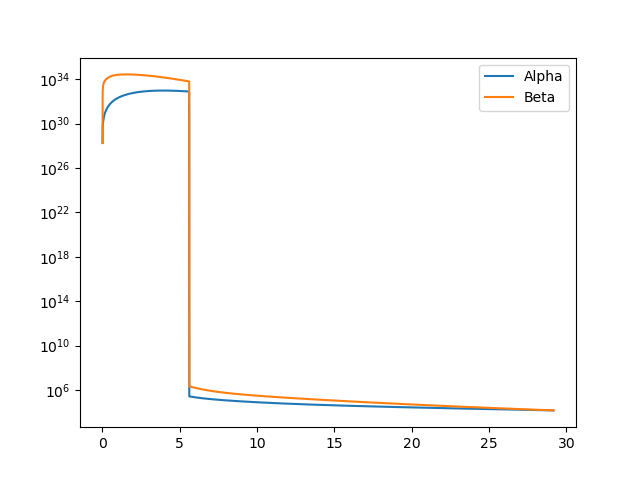

In [63]:
fig7 , ax7= plt.subplots(1,1,)
ax7.plot(tedias_1,L_1,label="Alpha")
ax7.plot(tedias_2,L_2,label="Beta")
ax7.set_yscale('log')
ax7.legend()
#ax7.set_ylim(bottom=10**10)

In [17]:
'''p=generar_graficas(0.05,0.02,0.15,10**10,0.001,5.2,100000,1,0)
U_1,L_1,T_1,tedias_1=p[0],p[1],p[2],p[3]

p2=generar_graficas(0.05,0.02,0.15,10**10,0.001,5.2,100000,2,0)
U_2,L_2,T_2,tedias_2=p2[0],p2[1],p2[2],p2[3]

p3=generar_graficas(0.05,0.02,0.15,10**10,0.001,5.2,100000,3,0)
U_3,L_3,T_3,tedias_3=p3[0],p3[1],p3[2],p3[3]

p4=generar_graficas(0.05,0.02,0.15,10**10,0.001,5.2,100000,4,E_beta_aporte[801]*f_beta)
U_4,L_4,T_4,tedias_4=p4[0],p4[1],p4[2],p4[3]

p5=generar_graficas(0.05,0.02,0.15,10**10,0.001,5.2,100000,4,E_beta_aporte[747]*f_beta)
U_5,L_5,T_5,tedias_5=p5[0],p5[1],p5[2],p5[3]

p6=generar_graficas(0.05,0.02,0.15,10**10,0.001,5.2,100000,4,E_beta_aporte[805]*f_beta)
U_6,L_6,T_6,tedias_6=p6[0],p6[1],p6[2],p6[3]

p7=generar_graficas(0.05,0.02,0.15,10**10,0.001,5.2,100000,4,E_beta_aporte[770]*f_beta)
U_7,L_7,T_7,tedias_7=p7[0],p7[1],p7[2],p7[3]

p8=generar_graficas(0.05,0.02,0.15,10**10,0.001,5.2,100000,4,E_beta_aporte[818]*f_beta)
U_8,L_8,T_8,tedias_8=p8[0],p8[1],p8[2],p8[3]

p9=generar_graficas(0.05,0.02,0.15,10**10,0.001,5.2,100000,4,E_beta_aporte[772]*f_beta)
U_9,L_9,T_9,tedias_9=p9[0],p9[1],p9[2],p9[3]

p10=generar_graficas(0.05,0.02,0.15,10**10,0.001,5.2,100000,4,E_beta_aporte[769]*f_beta)
U_10,L_10,T_10,tedias_10=p10[0],p10[1],p10[2],p10[3]



p4=generar_graficas(0.05,0.02,0.15,10**10,0.001,5.2,100000,4,E_alpha_aporte[292]*f_alpha)
U_4,L_4,T_4,tedias_4=p4[0],p4[1],p4[2],p4[3]

p5=generar_graficas(0.05,0.02,0.15,10**10,0.001,5.2,100000,4,E_alpha_aporte[471]*f_alpha)
U_5,L_5,T_5,tedias_5=p5[0],p5[1],p5[2],p5[3]

p6=generar_graficas(0.05,0.02,0.15,10**10,0.001,5.2,100000,4,E_alpha_aporte[298]*f_alpha)
U_6,L_6,T_6,tedias_6=p6[0],p6[1],p6[2],p6[3]

p7=generar_graficas(0.05,0.02,0.15,10**10,0.001,5.2,100000,4,E_alpha_aporte[341]*f_alpha)
U_7,L_7,T_7,tedias_7=p7[0],p7[1],p7[2],p7[3]
'''
#photo=generar_graficas(0.05,0.02,0.15,10**15,0.001,3.2,10000,3)
#U_3,L_3,T_3,tedias_3=photo[0],photo[1],photo[2],photo[3]


'p=generar_graficas(0.05,0.02,0.15,10**10,0.001,5.2,100000,1,0)\nU_1,L_1,T_1,tedias_1=p[0],p[1],p[2],p[3]\n\np2=generar_graficas(0.05,0.02,0.15,10**10,0.001,5.2,100000,2,0)\nU_2,L_2,T_2,tedias_2=p2[0],p2[1],p2[2],p2[3]\n\np3=generar_graficas(0.05,0.02,0.15,10**10,0.001,5.2,100000,3,0)\nU_3,L_3,T_3,tedias_3=p3[0],p3[1],p3[2],p3[3]\n\np4=generar_graficas(0.05,0.02,0.15,10**10,0.001,5.2,100000,4,E_beta_aporte[801]*f_beta)\nU_4,L_4,T_4,tedias_4=p4[0],p4[1],p4[2],p4[3]\n\np5=generar_graficas(0.05,0.02,0.15,10**10,0.001,5.2,100000,4,E_beta_aporte[747]*f_beta)\nU_5,L_5,T_5,tedias_5=p5[0],p5[1],p5[2],p5[3]\n\np6=generar_graficas(0.05,0.02,0.15,10**10,0.001,5.2,100000,4,E_beta_aporte[805]*f_beta)\nU_6,L_6,T_6,tedias_6=p6[0],p6[1],p6[2],p6[3]\n\np7=generar_graficas(0.05,0.02,0.15,10**10,0.001,5.2,100000,4,E_beta_aporte[770]*f_beta)\nU_7,L_7,T_7,tedias_7=p7[0],p7[1],p7[2],p7[3]\n\np8=generar_graficas(0.05,0.02,0.15,10**10,0.001,5.2,100000,4,E_beta_aporte[818]*f_beta)\nU_8,L_8,T_8,tedias_8=p8[0],p

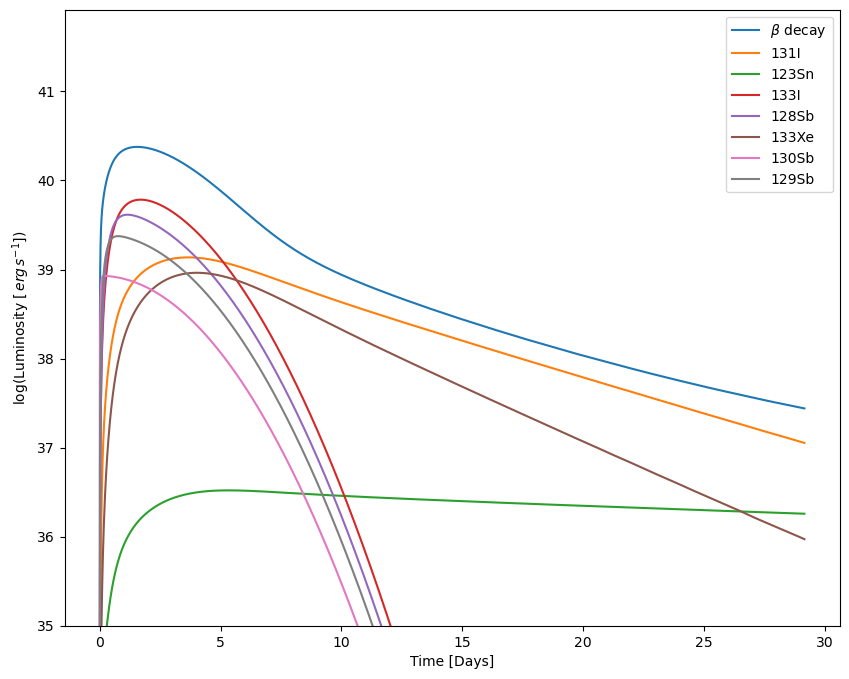

In [17]:
#datosLbol=pd.read_csv('Lbolcomas.txt')
#tiempo=datosLbol['time']
#Lbol=np.array(datosLbol['Lbol']*10**40)
plt.figure(figsize=(10,8))
#plt.plot(tedias_1,np.log10(L_1),label=r'$\epsilon$')
#plt.plot(tedias_2,np.log10(L_2),label=r'Total $f_{\alpha}\epsilon_{\alpha}$')
plt.plot(tedias_3,np.log10(L_3),label=r'$\beta$ decay')
'''
plt.plot(tedias_4,np.log10(L_4),label=Name_alpha[292])
plt.plot(tedias_5,np.log10(L_5),label=Name_alpha[471])
plt.plot(tedias_6,np.log10(L_6),label=Name_alpha[298])
plt.plot(tedias_7,np.log10(L_7),label=Name_alpha[341])
'''
plt.plot(tedias_4,np.log10(L_4),label=Name_beta[801])
plt.plot(tedias_5,np.log10(L_5),label=Name_beta[747])
plt.plot(tedias_6,np.log10(L_6),label=Name_beta[805])
plt.plot(tedias_7,np.log10(L_7),label=Name_beta[770])
plt.plot(tedias_8,np.log10(L_8),label=Name_beta[818])
plt.plot(tedias_9,np.log10(L_9),label=Name_beta[772])
plt.plot(tedias_10,np.log10(L_10),label=Name_beta[769])



#plt.scatter(tiempo,Lbol,label='bolometric light curve evolution GW170217',marker='d',c='#BF00BF')


plt.xlabel('Time [Days]')
plt.ylabel(r'log(Luminosity $[\,erg \, s^{-1}]$)')
plt.ylim(bottom=35)
plt.legend()
#plt.yscale('log')


